In [1]:
import quantiacsToolbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm
%matplotlib inline

data_path = '/Users/jacob/Desktop/docs/kaggle/two_sigma/_g_data/data'


import warnings
warnings.filterwarnings(action='ignore')

import datetime as dt

csv = pd.read_csv(data_path + '/sigma_data.csv', parse_dates=True, 
                 infer_datetime_format=True)

print(csv.shape)
csv.drop_duplicates(subset=['Date', 'asset'], inplace=True)
print(csv.shape)
csv.set_index('Date', inplace=True)

(57384, 10)
(36776, 10)


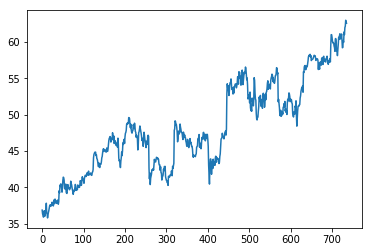

In [2]:
df = csv.copy()
qcom = np.array(df.query("asset == 'MSFT'")['Close']).reshape(-1, 1)
plt.plot(qcom);

In [3]:
qcom.shape

(736, 1)

In [8]:
# Takes some getting used to. Simply shifting the values and truncating
# so that vector operations can be performed
mom = (qcom[20:] - qcom[:-20]) / qcom[:-20]
# this will CHANGE dim
# consider
n = qcom.copy()
n[20:] = (n[20:] - n[:-20]) / n[:-20]
# then drop the first 20 later

For a (4 x 1) with a percent change for 2 days
\begin{eqnarray*}
\begin{bmatrix} 18 \\ 19 \\ 25 \\ 24 
\end{bmatrix}
- \begin{bmatrix} 12 \\ 16 \\ 18 \\ 19 
\end{bmatrix}
= \begin{bmatrix} 6 \\ 3 \\ 7 \\ 5 
\end{bmatrix}
/ \begin{bmatrix} 12 \\ 16 \\ 18 \\ 19 
\end{bmatrix} = momentum
\end{eqnarray*}

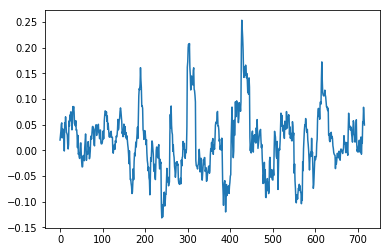

In [11]:
plt.plot(n[20:]);


In [12]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [13]:
# If you calcuate by hand, without inclusion of current, this works
x = np.array([5, 7, 6, 4, 8, 10])
r = np.cumsum(x)
r[3:] = r[3:] - r[:-3]
r[2:]/3

array([6.        , 5.66666667, 6.        , 7.33333333])

In [100]:
def ewma_infinite_hist(arr_in, window):
    """Exponentialy weighted moving average specified by a decay ``window``
    assuming infinite history via the recursive form:

        (2) (i)  y[0] = x[0]; and
            (ii) y[t] = a*x[t] + (1-a)*y[t-1] for t>0.

    Parameters
    ----------
    arr_in : np.ndarray, float64
        A single dimenisional numpy array
    window : int64
        The decay window, or 'span'

    Returns
    -------
    np.ndarray
        The EWMA vector, same length / shape as ``arr_in``

    """
    n = arr_in.shape[0]
    ewma = np.empty(n)
    alpha = 2 / float(window + 1)
    ewma[0] = arr_in[0]
    for i in range(1, n):
        ewma[i] = arr_in[i] * alpha + ewma[i-1] * (1 - alpha)
    return ewma

In [112]:
df = csv.copy()
msft = df.query("asset == 'MSFT'")[['Close']]

In [110]:
ar = msft.Close.values.copy()
import numpy.ma as ma

In [111]:
ar[1:] = ar[1:] - ar[:-1]
pos = ma.masked_where(ar[1:] < 0, ar[1:]).filled(0)
neg = abs(ma.masked_where(ar[1:] > 0, ar[1:]).filled(0))

x = ewma_infinite_hist(pos, 14)
y = ewma_infinite_hist(neg, 14)

(x / (x+y))[-10:]
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


## Pandas Implementation

In [113]:
 def rsi(x):    
        diff = x.diff()
        mask = diff < 0
        high = abs(diff.mask(mask)).fillna(0)
        low = abs(diff.mask(~mask)).fillna(0)
        pos_rsi = high.ewm(span=14).mean()
        neg_rsi = low.ewm(span=14).mean()
        
        del diff, mask, high, low
        
        return  pos_rsi / (pos_rsi + neg_rsi)
    

msft.apply(lambda x: rsi(x)).iloc[-10:]
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


In [103]:
msft.Close.iloc[:5]
m_v = msft.Close 
diff = m_v.diff()
mask = diff < 0
high = abs(diff.mask(mask)).fillna(0)
low = abs(diff.mask(~mask)).fillna(0)
pos_rsi = high.ewm(span=14).mean()
neg_rsi = low.ewm(span=14).mean()
pos_rsi[-10:]


Date
2016-12-02    0.202405
2016-12-05    0.304751
2016-12-06    0.264118
2016-12-07    0.418235
2016-12-08    0.362470
2016-12-09    0.442141
2016-12-12    0.409855
2016-12-13    0.463208
2016-12-14    0.401447
2016-12-15    0.347921
Name: Close, dtype: float64

In [31]:

alpha = 2 / 15
ewma(high, alpha)[-10:]
%time

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10 µs


https://stackoverflow.com/questions/42869495/numpy-version-of-exponential-weighted-moving-average-equivalent-to-pandas-ewm

In [97]:
_ewma_infinite_hist(high, 14)[-10:]


array([0.20240491, 0.30475108, 0.26411761, 0.41823501, 0.36247035,
       0.44214135, 0.40985543, 0.46320822, 0.40144713, 0.34792084])